# Calculate a 2D emissions grid incorporating COVID-19 effects for short-lived forcers

In [38]:
import netCDF4 as nc
import pandas as pd
import numpy as np
import reverse_geocoder as rg
import matplotlib.pyplot as plt

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point

ImportError: cannot import name 'insert_interpolated_point' from 'utils' (C:\Users\rlamboll\ConstrainCode\COVIDemissions\calculations\utils.py)

In [2]:
input_folder = "../input/aerosols/"
output_folder = "../output/"

# Input for the aerosols/gases
input_nox = "NOx-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_bc = "BC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_so2 = "SO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_oc = "OC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_co = "CO-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_nh3 = "NH3-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_nmvoc = "NMVOC-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.nc"
input_blip = "Robin_sectors_V3.csv"
convert_country_code_file = "convertCountryCodes.csv"
files_to_blip = [
    input_co, 
    input_nh3, input_nmvoc,
    input_oc, input_so2, input_nox, input_bc
]
key_variables = [
    "CO_em_anthro", 
    "NH3_em_anthro", "NMVOC_em_anthro",
    "OC_em_anthro", "SO2_em_anthro", "NOx_em_anthro", "BC_em_anthro"
]
# The name to affix on the variables output
scenario_string = "test.nc"

In [3]:
assert len(files_to_blip) == len(key_variables) # check input

## Collect and clean the data
We need to make the blip factors consistent with the netCDF data structure. This will require example data, although the results should not depend which example is chosen. 

In [4]:
nox_0 = nc.Dataset(input_folder + input_nox, "r", format="NETCDF4")
blip_factors = pd.read_csv(input_folder + input_blip)
convert_countries = pd.read_csv(input_folder + convert_country_code_file, keep_default_na=False, na_values=['_'])

In [5]:
data_to_modify = [nox_0]

In [6]:
for dimobj in nox_0.dimensions.values():
...     print(dimobj)

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 360
<class 'netCDF4._netCDF4.Dimension'>: name = 'sector', size = 8
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 120
<class 'netCDF4._netCDF4.Dimension'>: name = 'bound', size = 2


In [7]:
nox_0.variables["sector"]

<class 'netCDF4._netCDF4.Variable'>
int32 sector(sector)
    long_name: sector
    bounds: sector_bnds
    ids: 0: Agriculture; 1: Energy; 2: Industrial; 3: Transportation; 4: Residential, Commercial, Other; 5: Solvents production and application; 6: Waste; 7: International Shipping
unlimited dimensions: 
current shape = (8,)
filling on, default _FillValue of -2147483647 used

In [8]:
blip_factors = blip_factors[~blip_factors["1"].isna()]
blip_sectors = blip_factors["Sector"].unique()

## Perform the sector weighting


In [9]:
blip_sectors

array(['surface-transport', 'residential', 'public/commercial',
       'industry', 'international-shipping', 'international-aviation',
       'domestic-aviation', 'power'], dtype=object)

The set of sectors in our blip need to be converted into our sectors in the netCDF case. This uses:
0: Agriculture; 1: Energy; 2: Industrial; 3: Transportation; 4: Residential, Commercial, Other; 5: Solvents production and application; 6: Waste; 7: International Shipping

In [10]:
sector_dict = {"surface-transport": 3, "residential": 4, "public/commercial": -4, "industry": 2, 
 "international-shipping":7, "international-aviation": -1, "domestic-aviation": -2, "power": 1}
sectors_to_use = [1, 2, 3, 4, 5, 7]  # We will manage sectors 6 and 7 elsewhere, no change to sector 0 (agri).

In [11]:
blip_factors_multi = blip_factors.copy()
blip_factors_multi.drop(["Country", "Base(MtCO2/day)", "Unnamed: 0"], axis=1, inplace=True)
blip_factors_multi["Sector"] = [sector_dict[sect] for sect in blip_factors_multi["Sector"]]
blip_factors_multi.head()

,ISO_A3,Sector,Base%,1,2,3,4,5,6,7,...,357,358,359,360,361,362,363,364,365,366
0,ALB,3,42.007797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,DZA,3,31.360946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000
2,AGO,3,29.972754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429
3,ARG,3,23.181375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951
4,ARM,3,30.523255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [12]:
blip_factors_multi.set_index(blip_factors_multi.columns[:2].to_list(), drop=True, inplace=True)
blip_factors_multi.head()

,,Base%,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
ISO_A3,Sector,,,,,,,,,,,,,,,,,,,,,
ALB,3,42.007797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DZA,3,31.360946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000
AGO,3,29.972754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429
ARG,3,23.181375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951
ARM,3,30.523255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [13]:
# We want to average the two sets of sector 4 together in the right ratio
all_countries = blip_factors_multi.index.get_level_values("ISO_A3").unique()
for country in all_countries:
    if (country, 4) in blip_factors_multi.index and (country, -4) in blip_factors_multi.index:
        blip_factors_multi.loc[country, 4] = (
            blip_factors_multi.loc[country, 4].values * 
            blip_factors_multi["Base%"][country, 4] + 
            blip_factors_multi.loc[country, -4].values * blip_factors_multi["Base%"][country, -4]
            ) / (
                blip_factors_multi["Base%"][country, 4] + blip_factors_multi["Base%"][country, -4]
            )
        blip_factors_multi["Base%"][country, 4] = blip_factors_multi["Base%"][country, 4] + \
            blip_factors_multi["Base%"][country, -4]
        blip_factors_multi.drop((country, -4), inplace=True)
    elif (country, -4) in blip_factors_multi.index:
        blip_factors_multi.loc[country, 4] = blip_factors_multi.loc[country, -4]
    elif (country, 4) in blip_factors_multi.index:
        continue
    else:
        print("no data for {}".format(country))

In [14]:
# Test that this produces the right answers
example_factor = blip_factors[
    (blip_factors["ISO_A3"] == "GBR") & (blip_factors["Sector"].isin(["residential", "public/commercial"]))
][["Base%", "100"]]
assert np.isclose(blip_factors_multi.loc["GBR", 4][100], sum(
    example_factor["Base%"] * example_factor["100"]) / sum(example_factor["Base%"])
)

In [15]:
blip_factors_multi

,,Base%,1,2,3,4,5,6,7,8,9,...,357,358,359,360,361,362,363,364,365,366
ISO_A3,Sector,,,,,,,,,,,,,,,,,,,,,
ALB,3,42.007797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DZA,3,31.360946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000,-0.407000
AGO,3,29.972754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429,-0.394429
ARG,3,23.181375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951,-0.447951
ARM,3,30.523255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VEN,1,43.093385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102,-0.154102
VNM,1,31.822661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964,-0.077964
YEM,1,34.652509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565,-0.008565


We additionally assume that solvent production tracks industry.

In [16]:
for country in all_countries:
    blip_factors_multi.loc[(country, 5), :] = blip_factors_multi.loc[(country, 4), :]

In [17]:
blip_factors_multi.index.levels

FrozenList([['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRN', 'BWA', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COL', 'CRI', 'CUB', 'CUW', 'CYP', 'CZE', 'DEU', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIB', 'GRC', 'GTM', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 'KWT', 'LBN', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 'MEX', 'MKD', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MUS', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 'OMN', ...], [-4, -2, -1, 1, 2, 3, 4, 7, 5]])

## Derive country and date relation
We need to assign each lat/long a country. This is slightly complicated by the country index being 2 letters in the inverse geocoder but 3 letters in our data.

In [18]:
lat, lon = nox_0.variables["lat"][:], nox_0.variables["lon"][:]

In [19]:
convert_countries_dict = {convert_countries["A2 (ISO)"][i]: convert_countries["A3 (UN)"][i] for i in convert_countries.index}
coords = []
lon_length = len(lon)
for latperm in lat:
    coords = coords + list(zip([latperm] * lon_length, lon))

In [20]:
results = rg.search(coords)

Loading formatted geocoded file...


In [21]:
lat_countries_dict = {coords[i]: convert_countries_dict[results[i]["cc"]] for i in range(len(coords)) 
                      if results[i]["cc"] in convert_countries_dict.keys()}

The process will be faster if we map the other way and use the index rather than the coordinates:

In [22]:
country_coord_dict = {}
for k, v in lat_countries_dict.items():
    country_coord_dict[v] = country_coord_dict.get(v, [])
    country_coord_dict[v].append((np.where(lat.data == k[0])[0][0], np.where(lon.data == k[1])[0][0]))

Now we must relate the dates. blip_factors uses days from 2020-01-01, and has values for every day. The netCDFs use days since 2015-01-01, which is 5 * 365 + 1 days later and monthly. 

In [23]:
date_dif = 5 * 365 + 1
date_dif

1826

In [24]:
netCDF_times = nox_0.variables["time"][:]
netCDF_tseries = pd.Series(netCDF_times)
bliptimes = blip_factors_multi.columns[blip_factors_multi.columns != "Base%"]
bliptimes = pd.Series(pd.to_numeric(bliptimes))

In [25]:
time_dict = {}
remaining_times = bliptimes.copy()
mappable_times = netCDF_tseries[(netCDF_tseries > date_dif) & (netCDF_tseries < date_dif + max(bliptimes))]
for t in mappable_times.index[:-1]:
    closeTimes = [bliptime for bliptime in remaining_times if (
        0.5 * (mappable_times[t + 1] + mappable_times[t]) - date_dif > bliptime
    )]
    time_dict[mappable_times[t]] = closeTimes
    remaining_times = remaining_times[~remaining_times.isin(closeTimes)]
time_dict[mappable_times.iloc[-1]] = list(remaining_times)

In [26]:
blip_factors_av = pd.DataFrame(index=blip_factors_multi.index, columns=time_dict.keys())
for key, val in time_dict.items():
    blip_factors_av[key] = blip_factors_multi[list(str(v) for v in val)].mean(axis=1)

## Perform the emissions blip
We now have a mapping between times and locations and the emissions we want. 

In [27]:
nox_0.close()

In [28]:
all_valid_countries = [c for c in all_countries if c in country_coord_dict.keys()]

In [29]:
for fileind in range(len(files_to_blip)):
    file = files_to_blip[fileind]
    data = copy_netcdf_file(file, input_folder, output_folder, scenario_string)
    output = data.variables[key_variables[fileind]][:, :, :, :]
    print("Working on data for {}".format(key_variables[fileind]))
    for country in all_valid_countries:
        print(country)
        for time in blip_factors_av.columns:
            timeind = np.where(data.variables["time"][:] == time)[0]
            for sector in sectors_to_use:
                try:
                    mult_fact = blip_factors_av[time].loc[country, sector] + 1
                    if mult_fact != 1.0: #This saves operations
                        for lati, longi in country_coord_dict[country]:
                            output[timeind, sector, lati, longi] *= mult_fact
                except KeyError as e:
                    print("Key error for country {}".format(e))
                    break
    data.variables[key_variables[fileind]][:, :, :, :] = output

Working on data for CO_em_anthro
CHN
ALB
PRK
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
Key error for country ('PRK', 7)
KOR
Before, it is 1.5053342394821811e-07
After, it is 1.4424628602682787e-07
After, it is 1.4424628602682787e-07
Is data modified?


NameError: name 'arrays_equal' is not defined

## SANDBOX
Code below this line will break, but may be useful to use in some order to understand the data. 

In [ ]:
blob  # unassigned variable stops execution

In [ ]:
data.close()

In [ ]:
proc.close()

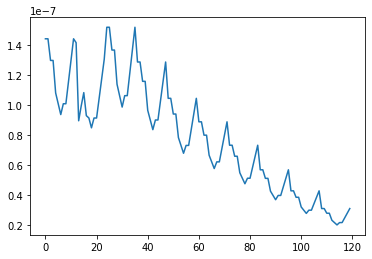

In [40]:
plt.plot(data.variables[key_variables[fileind]][:, 2, 262, 605] )

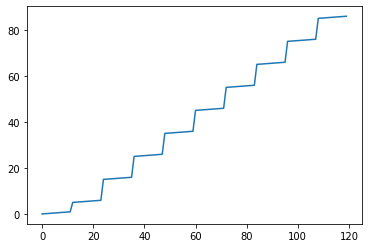

In [42]:
plt.plot(data.variables["time"][:] / 365)

In [31]:
print(arrays_equal(data.variables[key_variables[fileind]][:, :, :, :], output))

True


In [37]:
data.variables["lon"]

<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    units: degrees_east
    long_name: longitude
    axis: X
    bounds: lon_bnds
    modulo: 360.0
    realtopology: circular
    standard_name: longitude
    topology: circular
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [30]:
def arrays_equal(a, b):
    if a.shape != b.shape:
        return False
    for ai, bi in zip(a.flat, b.flat):
        if ai != bi:
            return False
    return True

In [ ]:
proc.variables[key_variables[trial_ind]][23, 2, 262, 605]

In [ ]:
np.where(data.variables[key_variables[fileind]][:, :, :, :] == data.variables[key_variables[fileind]][:, :, :, :].max())

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(((diff[17, 4, :, :]) != 0))

In [ ]:
plt.imshow(data.variables[key_variables[fileind]][25, 2, 250:270, 595:615] > 1e-13)

In [ ]:
trial_ind = 0
file = files_to_blip[trial_ind]
var = key_variables[trial_ind]
data = nc.Dataset(input_folder + file)
proc = nc.Dataset(output_folder + file + scenario_string)

In [ ]:
diff = data.variables[var][:, :, ::-1, :] - proc.variables[var][:, :, ::-1, :]

In [ ]:
diff.max()

In [ ]:
timeind

In [ ]:
blip_factors_av[time].loc[country, sector]

In [ ]:
ans = [state for state, _ in country_coord_dict.items() if state not in all_countries]
ans.sort()
print(ans)

In [ ]:
co2_0 = nc.Dataset(input_co2_mole)